In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import scipy.stats

In [2]:
# Question 1

df = pd.read_csv('invest.txt', sep=' ')
df.head()

,year,gnp,invest,cpi,interest
0,1968,873.4,133.3,82.54,5.16
1,1969,944.0,149.3,86.79,5.87
2,1970,992.7,144.2,91.45,5.95
3,1971,1077.6,166.4,96.01,4.88
4,1972,1185.9,195.0,100.00,4.50


[]

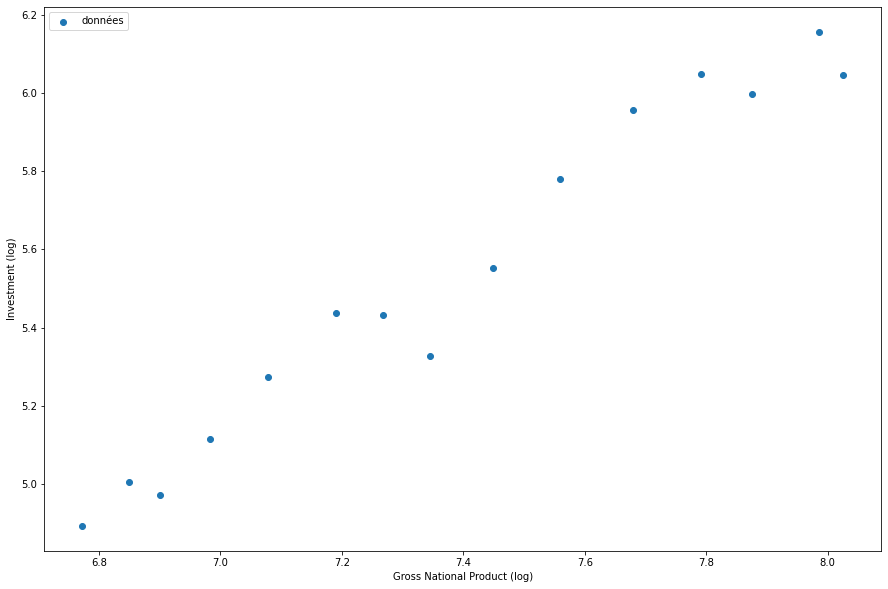

In [3]:
# Question 2

df = pd.read_csv('invest.txt', sep=' ')
df[['gnp', 'invest']] = np.log(df[['gnp', 'invest']])
X = df[['gnp']].values
Y = df[['invest']].values

plt.figure(figsize=(15,10))
plt.xlabel('Gross National Product (log)')
plt.ylabel('Investment (log)')

plt.scatter(X, Y, label='données')

plt.legend(loc='upper left')
plt.plot()

In [4]:
# Question 3

def transform_X_to_Z(X):
    if np.ndim(X) == 1:
        X = X.reshape(-1,1)
    return np.concatenate((np.ones(np.shape(X)[0]).reshape(-1, 1), X), axis=1)


def get_gramm_matrix(Z):
    return Z.T @ Z / np.shape(Z)[0]


def get_diag_inv_G(Z):
    return np.diag(np.linalg.inv(get_gramm_matrix(Z=Z)))


def get_theta(Z, Y):
    return np.linalg.inv(Z.T @ Z) @ Z.T @ Y


def predict_values(Z, theta):
    return Z @ theta


def get_coeff_deter(Z, Y, theta):
    return 1 - np.sum((Y - predict_values(Z=Z, theta=theta)) ** 2) / np.sum((Y - np.mean(Y)) ** 2)


def get_degree(Z):
    return Z.shape[0] - Z.shape[1]


def get_residual_std(Z, Y, theta):
    return np.sqrt(np.sum((Y - predict_values(Z=Z, theta=theta)) ** 2) / get_degree(Z))


def get_theta_std(Z, Y, theta):
    return np.sqrt(np.diag((get_residual_std(Z=Z, Y=Y, theta=theta) ** 2) * np.linalg.inv(Z.T @ Z)))


Z = transform_X_to_Z(X=X)

theta = get_theta(Z=Z, Y=Y)
theta_std = get_theta_std(Z=Z, Y=Y, theta=theta)
coeff_deter = get_coeff_deter(Z=Z, Y=Y, theta=theta)

print(f'La valeur de l\'intercept est : {theta.squeeze()[0]:.4f}')
print(f'La valeur de la pente est : {theta.squeeze()[1]:.4f}')
print(f'La valeur des écart-type de theta0 et theta1 sont : {theta_std[0]:.4f} et {theta_std[1]:.4f}')
print(f'La valeur du coefficient de détermination est : {coeff_deter:.4f}')

La valeur de l'intercept est : -1.9636
La valeur de la pente est : 1.0153
La valeur des écart-type de theta0 et theta1 sont : 0.4095 et 0.0554
La valeur du coefficient de détermination est : 0.9628


In [5]:
# Question 4

def get_ttest(Z, Y, theta):
    return np.squeeze(np.sqrt(Z.shape[0]) * theta) / np.sqrt((get_residual_std(Z=Z, Y=Y, theta=theta) ** 2) * get_diag_inv_G(Z=Z))


def get_pvalue(Z, Y, theta):
    return 2 * scipy.stats.t.sf(x=get_ttest(Z=Z, Y=Y, theta=theta), df=get_degree(Z))


ttest = get_ttest(Z=Z, Y=Y, theta=theta)
pvalue = get_pvalue(Z=Z, Y=Y, theta=theta)

print(f'La valeur de ttest pour theta1 est : {ttest[1]:.4f}')
print(f'La valeur de pvalue pour theta1 est : {pvalue[1]:.4f}')

La valeur de ttest pour theta1 est : 18.3320
La valeur de pvalue pour theta1 est : 0.0000


In [6]:
# Question 5

def get_student_percentile(Z, alpha):
    return scipy.stats.t.ppf(q=alpha, df=get_degree(Z))


def get_CI(Z, Y, theta, alpha, z_pred):
    center = np.squeeze(z_pred @ theta)
    percentile = get_student_percentile(Z=Z, alpha=(1-alpha/2))
    residual_std = get_residual_std(Z=Z, Y=Y, theta=theta)
    mid_length = percentile * residual_std * np.sqrt(np.diag(z_pred @ (np.linalg.inv(Z.T @ Z)) @ z_pred.T))
    a = np.diag(z_pred @ (np.linalg.inv(Z.T @ Z)) @ z_pred.T)
    return center - mid_length, center + mid_length


def get_PI(Z, Y, theta, alpha, z_pred):
    center = np.squeeze(z_pred @ theta)
    percentile = get_student_percentile(Z=Z, alpha=(1-alpha/2))
    residual_std = get_residual_std(Z=Z, Y=Y, theta=theta)
    mid_length = percentile * residual_std * np.sqrt(np.diag(1 + z_pred @ (np.linalg.inv(Z.T @ Z)) @ z_pred.T))
    return center - mid_length, center + mid_length


z_pred = transform_X_to_Z(np.log(np.array([1000])))

y1000 = predict_values(Z=z_pred, theta=theta)
CI_lower, CI_upper = get_CI(Z=Z, Y=Y, theta=theta, alpha=0.10, z_pred=z_pred)
PI_lower, PI_upper = get_PI(Z=Z, Y=Y, theta=theta, alpha=0.10, z_pred=z_pred)
print(f'La valeur de y_1000 est : {y1000.squeeze():.4f}')
print(f'Les valeurs des bornes de CI sont : {CI_lower.squeeze():.4f} et {CI_upper.squeeze():.4f}')
print(f'Les valeurs des bornes de PI sont : {PI_lower.squeeze():.4f} et {PI_upper.squeeze():.4f}')

La valeur de y_1000 est : 5.0497
Les valeurs des bornes de CI sont : 4.9882 et 5.1112
Les valeurs des bornes de PI sont : 4.8828 et 5.2166


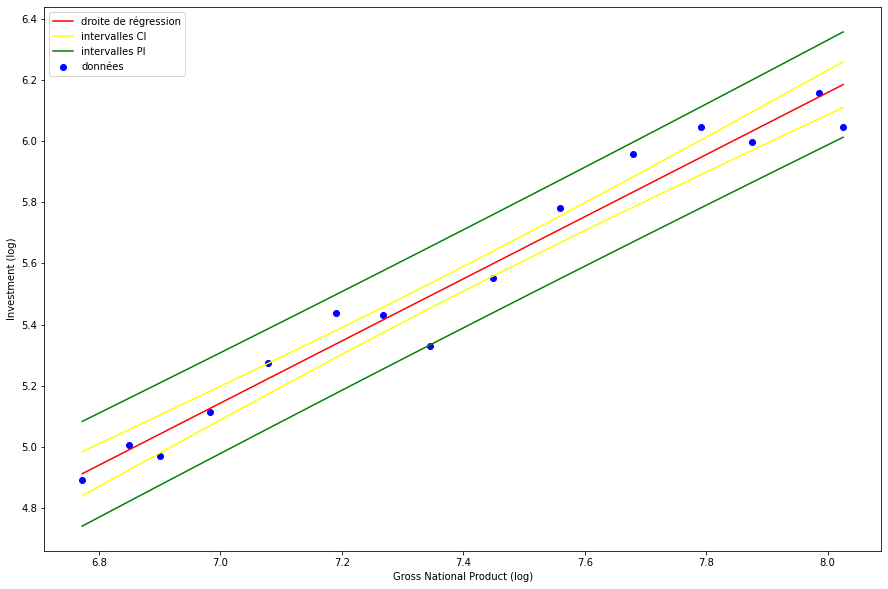

In [7]:
# Question 6

def plot_q6(Z, Y, theta):
    plt.figure(figsize=(15,10))
    plt.xlabel('Gross National Product (log)')
    plt.ylabel('Investment (log)')
    
    all_CI_lower, all_CI_upper = get_CI(Z=Z, Y=Y, theta=theta, alpha=0.10, z_pred=Z)
    all_PI_lower, all_PI_upper = get_PI(Z=Z, Y=Y, theta=theta, alpha=0.10, z_pred=Z)
    
    plt.scatter(Z[:,1], Y, color='blue', label='données')
    plt.plot(Z[:,1], predict_values(Z=Z, theta=theta), color='red', label='droite de régression')
    plt.plot(Z[:,1], all_CI_lower, color='yellow', label='intervalles CI')
    plt.plot(Z[:,1], all_CI_upper, color='yellow')
    plt.plot(Z[:,1], all_PI_lower, color='green', label='intervalles PI')
    plt.plot(Z[:,1], all_PI_upper, color='green')
    
    plt.legend(loc='upper left')
    plt.plot()


plot_q6(Z=Z, Y=Y, theta=theta)

In [8]:
# Question 7 

def check_values(X, Y, x_pred):
    skl_lm = sklearn.linear_model.LinearRegression()
    skl_lm.fit(X, Y)
    true_Yhat = skl_lm.intercept_ + X @ skl_lm.coef_.reshape(-1,1)
    true_coeff_deter = sklearn.metrics.r2_score(Y, true_Yhat)
    true_y1000 = skl_lm.predict(x_pred)
    return skl_lm.intercept_, skl_lm.coef_, true_coeff_deter, true_y1000


true_theta0, true_thetacoeff, true_coeff_deter, true_y1000 = check_values(X=X, Y=Y, x_pred=np.log([[1000]]))
print(f'Les valeurs de theta0 réelle et trouvée aux questions précédentes sont identiques : {np.isclose(theta.squeeze()[0],true_theta0.squeeze())}')
print(f'Les valeurs de theta1 réelle et trouvée aux questions précédentes sont identiques : {np.isclose(theta.squeeze()[1],true_thetacoeff.squeeze())}')
print(f'Les valeurs de coeff_deter réelle et trouvée aux questions précédentes sont identiques : {np.isclose(coeff_deter,true_coeff_deter)}')
print(f'Les valeurs de y1000 réelle et trouvée aux questions précédentes sont identiques : {np.isclose(y1000.squeeze(),true_y1000.squeeze())}')

Les valeurs de theta0 réelle et trouvée aux questions précédentes sont identiques : True
Les valeurs de theta1 réelle et trouvée aux questions précédentes sont identiques : True
Les valeurs de coeff_deter réelle et trouvée aux questions précédentes sont identiques : True
Les valeurs de y1000 réelle et trouvée aux questions précédentes sont identiques : True


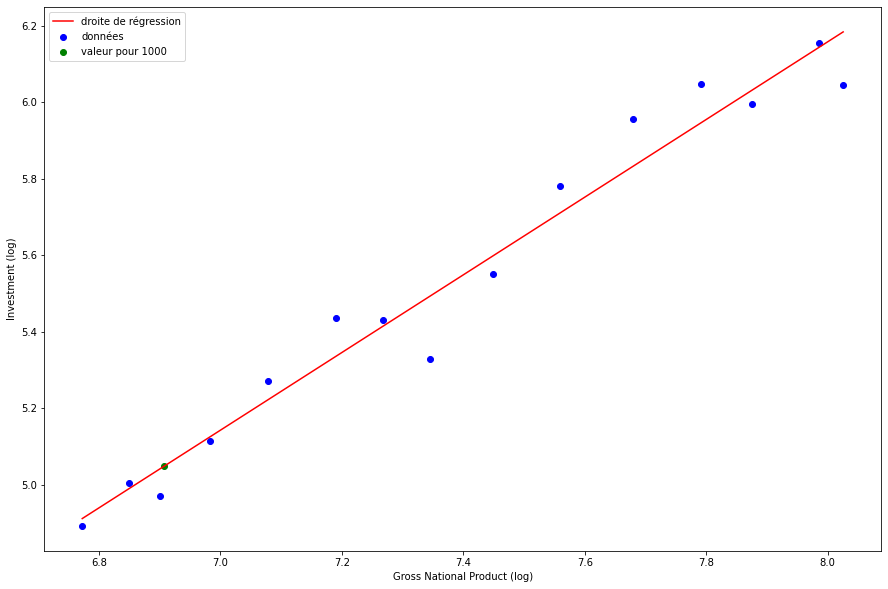

In [9]:
# Question 8

def plot_q8(Z, Y, theta):
    plt.figure(figsize=(15,10))
    plt.xlabel('Gross National Product (log)')
    plt.ylabel('Investment (log)')
    
    x1000 = np.log(np.array([1000]))
    y1000 = predict_values(Z=transform_X_to_Z(x1000), theta=theta)
    
    plt.scatter(Z[:,1], Y, color='blue', label='données')
    plt.plot(Z[:,1], predict_values(Z=Z, theta=theta), color='red', label='droite de régression')
    plt.scatter(x1000, y1000, color='green', label='valeur pour 1000')
    
    plt.legend(loc='upper left')
    plt.plot()


plot_q8(Z=Z, Y=Y, theta=theta)

In [10]:
# Question 9

def check_full_rank(mat):
    return np.min(mat.shape) == np.linalg.matrix_rank(mat) 

X_2 = df[['gnp', 'interest']].values
Z_2 = transform_X_to_Z(X=X_2)
Y_2 = df[['invest']].values

print(f'La matrice de Gramm est de plein rang : {check_full_rank(get_gramm_matrix(Z_2))}')

La matrice de Gramm est de plein rang : True


In [11]:
# Question 10

theta_2 = get_theta(Z=Z_2, Y=Y_2)
theta_std_2 = get_theta_std(Z=Z_2, Y=Y_2, theta=theta_2)
coeff_deter_2 = get_coeff_deter(Z=Z_2, Y=Y_2, theta=theta_2)
ttest_2 = get_ttest(Z=Z_2, Y=Y_2, theta=theta_2)
pvalue_2 = get_pvalue(Z=Z_2, Y=Y_2, theta=theta_2)

print(get_residual_std(Z=Z_2, Y=Y_2, theta=theta_2) ** 2)

print(f'Les valeurs de theta0, theta1 et theta2 sont : {theta_2.squeeze()[0]:.4f}, {theta_2.squeeze()[1]:.4f} et {theta_2.squeeze()[2]:.4f}')
print(f'La valeur des écart-type de theta0, theta1 et theta2 sont : {theta_std_2[0]:.4f}, {theta_std_2[1]:.4f} et {theta_std_2[2]:.4f}')
print(f'La valeur du coefficient de détermination est : {coeff_deter_2:.4f}')
print(f'Les valeurs de ttest pour theta0, theta1 et theta2 sont : {ttest_2[0]:.4f}, {ttest_2[1]:.4f}, {ttest_2[2]:.4f}')
print(f'Les valeurs de pvalue pour theta0, theta1 et theta2 sont : {pvalue_2[0]:.4f}, {pvalue_2[1]:.4f} et {pvalue_2[2]:.4f}')

0.008192432955519809
Les valeurs de theta0, theta1 et theta2 sont : -2.1805, 1.0512 et -0.0065
La valeur des écart-type de theta0, theta1 et theta2 sont : 0.6624, 0.1021 et 0.0153
La valeur du coefficient de détermination est : 0.9633
Les valeurs de ttest pour theta0, theta1 et theta2 sont : -3.2918, 10.3001, -0.4255
Les valeurs de pvalue pour theta0, theta1 et theta2 sont : 1.9936, 0.0000 et 1.3220


In [12]:
# Question 11

z_pred_2 = transform_X_to_Z(np.array([[np.log(1000), 10]]))
y1000_2 = predict_values(Z=z_pred_2, theta=theta_2)
CI_lower_2, CI_upper_2 = get_CI(Z=Z_2, Y=Y_2, theta=theta_2, alpha=0.001, z_pred=z_pred_2)
PI_lower_2, PI_upper_2 = get_PI(Z=Z_2, Y=Y_2, theta=theta_2, alpha=0.001, z_pred=z_pred_2)
print(f'La valeur de y_1000 est : {y1000_2.squeeze():.4f}')
print(f'Les valeurs des bornes de CI sont : {CI_lower_2.squeeze():.4f} et {CI_upper_2.squeeze():.4f}')
print(f'Les valeurs des bornes de PI sont : {PI_lower_2.squeeze():.4f} et {PI_upper_2.squeeze():.4f}')

La valeur de y_1000 est : 5.0160
Les valeurs des bornes de CI sont : 4.6402 et 5.3918
Les valeurs des bornes de PI sont : 4.4738 et 5.5582


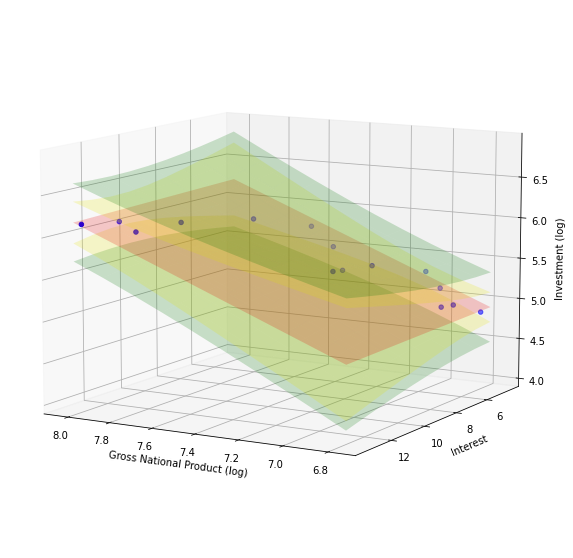

In [13]:
# Question 12
from mpl_toolkits.mplot3d import Axes3D


def plot_q12(Z, Y, theta):
    abs_val = np.linspace(np.min(Z[:,1]), np.max(Z[:,1]), 10)
    ord_val = np.linspace(np.min(Z[:,2]), np.max(Z[:,2]), 10)
    abs_val, ord_val = np.meshgrid(abs_val, ord_val)
    
    input_val = transform_X_to_Z(np.concatenate((abs_val.reshape(-1,1), ord_val.reshape(-1,1)), axis=1))

    app_pred_val = predict_values(Z=input_val, theta=theta)
    CI_lower_2, CI_upper_2 = get_CI(Z=Z, Y=Y, theta=theta, alpha=0.001, z_pred=input_val)
    PI_lower_2, PI_upper_2 = get_PI(Z=Z, Y=Y, theta=theta, alpha=0.001, z_pred=input_val)
    
    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')
    ax.scatter(xs=Z[:,1], ys=Z[:,2], zs=Y, color='blue')
    ax.plot_surface(X=abs_val, Y=ord_val, Z=app_pred_val.reshape(10,10), alpha=0.2, color='red')
    ax.plot_surface(X=abs_val, Y=ord_val, Z=CI_lower_2.reshape(10,10), alpha=0.2, color='yellow')
    ax.plot_surface(X=abs_val, Y=ord_val, Z=CI_upper_2.reshape(10,10), alpha=0.2, color='yellow')
    ax.plot_surface(X=abs_val, Y=ord_val, Z=PI_lower_2.reshape(10,10), alpha=0.2, color='green')
    ax.plot_surface(X=abs_val, Y=ord_val, Z=PI_upper_2.reshape(10,10), alpha=0.2, color='green')
    
    ax.set_xlabel('Gross National Product (log)')
    ax.set_ylabel('Interest')
    ax.set_zlabel('Investment (log)')
    ax.view_init(10, 120)
    plt.draw()
    


plot_q12(Z=Z_2, Y=Y_2, theta=theta_2)

In [14]:
true_theta0_2, true_thetacoeff_2, true_coeff_deter_2, true_y1000_2 = check_values(X=X_2, Y=Y_2, x_pred=np.array([[np.log(1000), 10]]))

print(f'Les valeurs de theta0 réelle et trouvée aux questions précédentes sont identiques : {np.isclose(theta_2.squeeze()[0],true_theta0_2.squeeze())}')
print(f'Les valeurs de theta1 réelle et trouvée aux questions précédentes sont identiques : {np.isclose(theta_2.squeeze()[1],true_thetacoeff_2.squeeze()[0])}')
print(f'Les valeurs de theta2 réelle et trouvée aux questions précédentes sont identiques : {np.isclose(theta_2.squeeze()[2],true_thetacoeff_2.squeeze()[1])}')
print(f'Les valeurs de coeff_deter réelle et trouvée aux questions précédentes sont identiques : {np.isclose(coeff_deter_2,true_coeff_deter_2)}')
print(f'Les valeurs de y1000 réelle et trouvée aux questions précédentes sont identiques : {np.isclose(y1000_2.squeeze(),true_y1000_2.squeeze())}')

Les valeurs de theta0 réelle et trouvée aux questions précédentes sont identiques : True
Les valeurs de theta1 réelle et trouvée aux questions précédentes sont identiques : True
Les valeurs de theta2 réelle et trouvée aux questions précédentes sont identiques : True
Les valeurs de coeff_deter réelle et trouvée aux questions précédentes sont identiques : True
Les valeurs de y1000 réelle et trouvée aux questions précédentes sont identiques : True
